# Binary Classification using Logistic Regression

* Logistic Regression is used for **classification**, not regression.

* It predicts the **probability** of a class (e.g., 0 or 1).

* Uses the **sigmoid function** to squeeze output between **0 and 1**.

* Decision rule:

  * Probability ≥ 0.5 → class 1
  * Probability < 0.5 → class 0

* Works well when:

  * Classes are **linearly separable**,
  * You need a **fast**, simple model.

* Supports **regularization** (L1, L2) to avoid overfitting.

* For more than 2 classes, it uses **OvR** or **Softmax (Multinomial)**.


In [1]:
# ================================
# 1. Import Libraries
# ================================
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
# ================================
# 2. Load Dataset
# ================================
df = sns.load_dataset("titanic")

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [3]:
# Keep a few useful columns
df = df[["survived", "pclass", "sex", "age", "fare", "alone"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   fare      891 non-null    float64
 5   alone     891 non-null    bool   
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 35.8+ KB


In [4]:
# Drop rows with missing values
df = df.dropna()

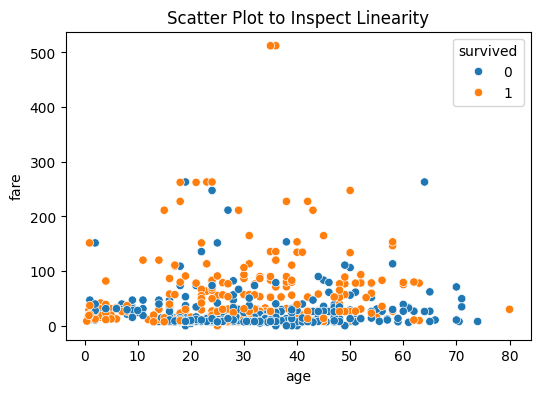

In [5]:
# ---- 1. VISUAL CHECK ----
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['age'],y=df['fare'],hue=df['survived'])
plt.title("Scatter Plot to Inspect Linearity")
plt.show()

In [6]:
# --- Encoding (convert categorical to numeric)
df["sex"] = df["sex"].map({"male": 0, "female": 1})
df["alone"] = df["alone"].astype(int)

In [7]:
# --- Log transform example (for skewed features)
df["fare_log"] = np.log1p(df["fare"])   # log(1+fare)

In [8]:
# ================================
# 4. Split Data
# ================================
X = df[["pclass", "sex", "age", "fare_log", "alone"]]
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(571, 5)
(571,)
(143, 5)
(143,)


In [9]:
# ================================
# 5. Scaling
# ================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print("\n=== Logistic Regression (Normal) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


=== Logistic Regression (Normal) ===
Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

           0       0.77      0.78      0.78        87
           1       0.65      0.64      0.65        56

    accuracy                           0.73       143
   macro avg       0.71      0.71      0.71       143
weighted avg       0.73      0.73      0.73       143



AUC Score: 0.8086001642036125


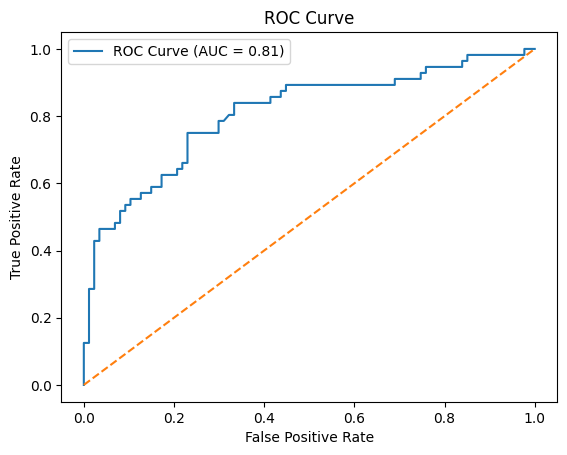

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for class 1
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

print("AUC Score:", roc_auc)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Lasso Logistic Regression (L1)

* L1 drives coefficients to exactly zero → feature selection

* C controls strength:

    Small C → stronger regularization → more coefficients become zero

    Large C → weaker regularization

In [12]:
lasso = LogisticRegression(
    penalty="l1",
    solver="liblinear",   # or saga for multiclassification
    C=1.0
)
lasso.fit(X_train_scaled, y_train)
pred_lasso = lasso.predict(X_test_scaled)

print("\n=== Lasso Logistic Regression (L1) ===")
print("Accuracy:", accuracy_score(y_test, pred_lasso))
print(classification_report(y_test, pred_lasso))



=== Lasso Logistic Regression (L1) ===
Accuracy: 0.7342657342657343
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        87
           1       0.66      0.66      0.66        56

    accuracy                           0.73       143
   macro avg       0.72      0.72      0.72       143
weighted avg       0.73      0.73      0.73       143



## Ridge Logistic Regression (L2)

* L2 shrinks coefficients but never makes them zero.

* This means no feature selection, all features stay in the model.

* Small C = strong regularization → coefficients shrink more.

* Large C = weak regularization → coefficients shrink less.

* Useful for reducing overfitting and handling multicollinearity.

In [13]:
ridge = LogisticRegression(
    penalty="l2",
    C=1.0
)
ridge.fit(X_train_scaled, y_train)
pred_ridge = ridge.predict(X_test_scaled)

print("\n=== Ridge Logistic Regression (L2) ===")
print("Accuracy:", accuracy_score(y_test, pred_ridge))
print(classification_report(y_test, pred_ridge))


=== Ridge Logistic Regression (L2) ===
Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

           0       0.77      0.78      0.78        87
           1       0.65      0.64      0.65        56

    accuracy                           0.73       143
   macro avg       0.71      0.71      0.71       143
weighted avg       0.73      0.73      0.73       143



# **Multiclass Classification with Logistic Regression**

* Logistic Regression can handle **more than two classes** using two strategies:

  **1. One-vs-Rest (OvR)**

  * Default in scikit-learn.
  * Creates **one logistic regression model per class**.
  * Each model predicts: “Is this sample class *k* or not?”

  **2. Multinomial (Softmax Regression)**

  * Uses **softmax function** to output probabilities for **all classes at once**.
  * Usually gives better performance than OvR.
  * Requires solvers like `lbfgs`, `saga`, or `newton-cg`.

* The model outputs **class probabilities**, and the class with the highest probability becomes the prediction.

* Regularization still applies (L1/L2), and `C` controls the strength.

* Common use cases: digit recognition, iris flowers classification, sentiment categories, etc.


In [14]:
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Load dataset
iris = load_iris()
X = iris.data               # features
y = iris.target             # target (3 classes)

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# Multiclass Logistic Regression (Softmax)
model = LogisticRegression(
    multi_class="multinomial",
    max_iter=500
)

model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=500, multi_class='multinomial')

In [18]:
# Predictions
y_pred = model.predict(X_test)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



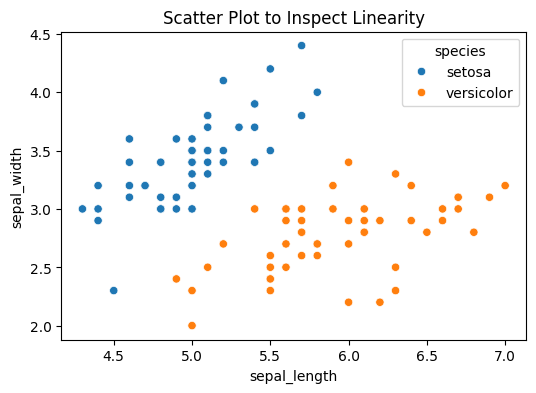

Logistic Regression Accuracy: 1.0
SVM (RBF) Accuracy: 1.0


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load dataset
data = sns.load_dataset("iris")

# We'll check if we can linearly separate Setosa vs Versicolor
df = data[data['species'] != 'virginica']  # keep only 2 classes

X = df[['sepal_length', 'sepal_width']]
y = df['species']

# ---- 1. VISUAL CHECK ----
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='sepal_length', y='sepal_width', hue='species')
plt.title("Scatter Plot to Inspect Linearity")
plt.show()

# ---- 2. MODEL CHECK ----

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression (linear boundary)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, logreg_pred))

# Nonlinear SVM (curved boundary)
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print("SVM (RBF) Accuracy:", accuracy_score(y_test, svm_pred))
